In [ ]:
!pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.2/182.2 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 4.9 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


No backend selected.
Finding available backend...
Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [ ]:
# Parameters
alpha = 1 / 10  # 1/평균감염기간
beta_init = alpha * 5  # 초기 감염전파율
n0 = 1000
v = 0
mu = 0
a = 0

# Initial conditions
u1_0 = 990
u2_0 = 10
u3_0 = 0
initial_conditions = [u1_0, u2_0, u3_0]

# Time span
t_max = 50
t_span = (0, t_max)
t_eval = np.linspace(0, t_max, 1000)

# Define the ODE system for generating synthetic data
def ode_system(t, u):
    S, I, R = u
    dS_dt = mu * n0 - beta_init * S * I / n0 - v * S - mu * S
    dI_dt = beta_init * S * I / n0 - alpha * I - mu * I - a * I
    dR_dt = alpha * I + v * S - mu * R + a * I
    return [dS_dt, dI_dt, dR_dt]

# Solve the ODE system
solution = solve_ivp(ode_system, t_span, initial_conditions, t_eval=t_eval)

# Extract the solution
S_data = solution.y[0]
I_data = solution.y[1]
R_data = solution.y[2]
data = np.stack((S_data, I_data, R_data), axis=-1)
t_data = solution.t[:, None]  # Make sure t_data has the correct shape

# Define the geometry
geom = dde.geometry.TimeDomain(0, t_max)

# Define initial conditions for the PDE model
def boundary_init(t, on_initial):
    return on_initial

ic1 = dde.icbc.IC(geom, lambda X: u1_0, boundary_init, component=0)
ic2 = dde.icbc.IC(geom, lambda X: u2_0, boundary_init, component=1)
ic3 = dde.icbc.IC(geom, lambda X: u3_0, boundary_init, component=2)

# Define the variable beta(t)
beta = dde.Variable(0.5)

# Define the time-dependent beta(t)
def beta_t(t):
    return beta

# Define the ODE system with time-dependent beta(t)
def ode(t, u):
    S = u[:, 0:1]
    I = u[:, 1:2]
    R = u[:, 2:3]

    dS_t = dde.grad.jacobian(u, t, i=0)
    dI_t = dde.grad.jacobian(u, t, i=1)
    dR_t = dde.grad.jacobian(u, t, i=2)

    beta_t_value = beta_t(t)

    ode1 = dS_t - (mu * n0 - beta_t_value * S * I / n0 - v * S - mu * S)
    ode2 = dI_t - (beta_t_value * S * I / n0 - alpha * I - mu * I - a * I)
    ode3 = dR_t - (alpha * I + v * S - mu * R + a * I)

    return [ode1, ode2, ode3]

# Create data object, including the true solution as training data
observe_u1 = dde.icbc.PointSetBC(t_data, S_data[:, None], component=0)
observe_u2 = dde.icbc.PointSetBC(t_data, I_data[:, None], component=1)
observe_u3 = dde.icbc.PointSetBC(t_data, R_data[:, None], component=2)

data = dde.data.TimePDE(geom, ode, [ic1, ic2, ic3, observe_u1, observe_u2, observe_u3], num_domain=5000, num_boundary=500, num_test=1000)

# Define the neural network for the ODE system
layer_size = [1] + [30] * 2 + [3]
activation = "tanh"
initializer = "Glorot uniform"
net_ode = dde.maps.FNN(layer_size, activation, initializer)

# Combine the two networks
model = dde.Model(data, net_ode)

# Trainable variable
external_trainable_variables = [beta]
variable = dde.callbacks.VariableValue(
    external_trainable_variables, period=600, filename="variables.dat"
)

# Train the model using Adam optimizer
model.compile("adam", lr=1e-2, external_trainable_variables=external_trainable_variables)
losshistory, train_state = model.train(iterations=20000, callbacks=[variable])

Compiling model...
Building feed-forward neural network...
'build' took 0.176831 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.381253 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [9.90e-03, 3.75e-03, 1.33e-02, 9.80e+05, 1.00e+02, 0.00e+00, 1.76e+05, 6.04e+04, 4.52e+05]    [4.11e-03, 3.91e-03, 7.17e-03, 9.80e+05, 1.00e+02, 0.00e+00, 1.76e+05, 6.04e+04, 4.52e+05]    []  
1000      [1.52e+02, 1.02e+02, 2.72e+02, 4.76e+05, 1.56e+03, 1.25e+04, 8.20e+04, 2.53e+04, 2.05e+05]    [1.59e+02, 1.10e+02, 2.83e+02, 4.76e+05, 1.56e+03, 1.25e+04, 8.20e+04, 2.53e+04, 2.05e+05]    []  
2000      [2.49e+02, 9.70e+01, 3.97e+02, 2.11e+05, 7.27e+02, 1.97e+04, 5.56e+04, 2.44e+04, 1.05e+05]    [2.62e+02, 1.05e+02, 4.17e+02, 2.11e+05, 7.27e+02, 1.97e+04, 5.56e+04, 2.44e+04, 1.05e+05]    []  
3000      [2.62e+02, 7.40e+01, 4.11e+02, 8.38e+04, 5.46e+02, 1.29e+04, 5.28e+04, 2.19e+04, 6.34e+04]    [2.74e+02, 8.00e+01, 4.32e+02, 

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


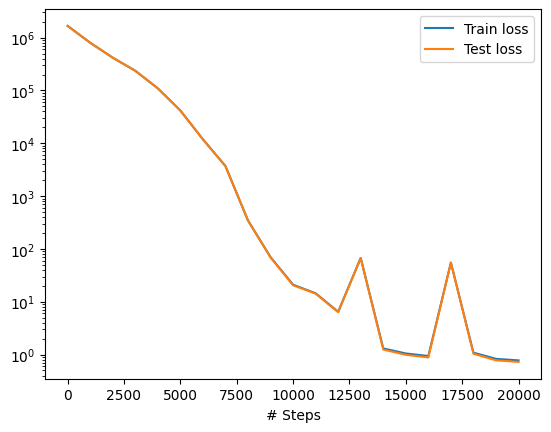

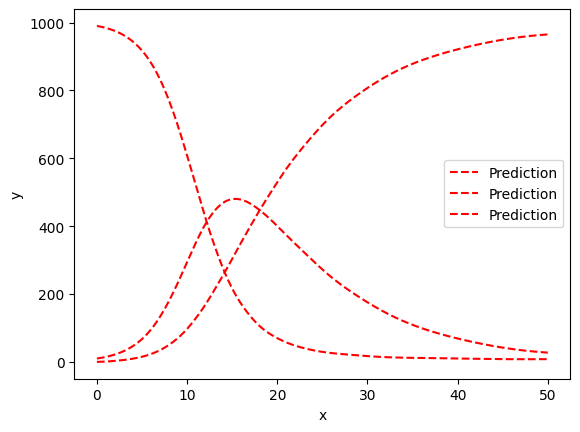

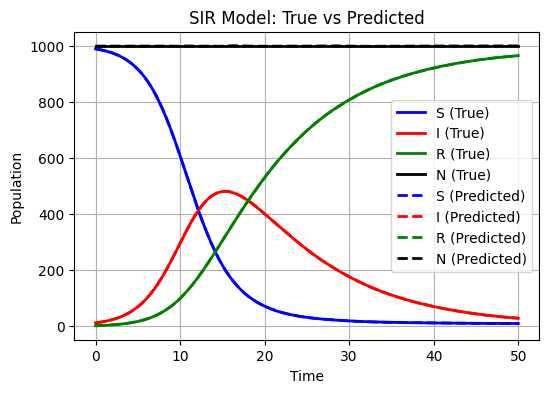

AttributeError: 'RefVariable' object has no attribute 'predict'

In [ ]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

# Extract the trained solution
X = geom.uniform_points(1000, True)
y = model.predict(X)

# Plot the results for S, I, R
plt.figure(figsize=(6, 4))
plt.plot(t_data, S_data, 'b-', label='S (True)', linewidth=2)
plt.plot(t_data, I_data, 'r-', label='I (True)', linewidth=2)
plt.plot(t_data, R_data, 'g-', label='R (True)', linewidth=2)
plt.plot(t_data, S_data+I_data+R_data, 'k-', label='N (True)', linewidth=2)
plt.plot(X, y[:, 0], 'b--', label='S (Predicted)', linewidth=2)
plt.plot(X, y[:, 1], 'r--', label='I (Predicted)', linewidth=2)
plt.plot(X, y[:, 2], 'g--', label='R (Predicted)', linewidth=2)
plt.plot(X, y[:, 0]+y[:, 1]+y[:, 2], 'k--', label='N (Predicted)', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.title('SIR Model: True vs Predicted')
plt.grid(True)
plt.show()

# Generate time values for beta(t) and predict
t_values = np.linspace(0, t_max, 1000)[:, None]
beta_values = beta.predict(t_values)

# Plot beta(t)
plt.figure(figsize=(6, 4))
plt.plot(t_values, beta_values, 'm-', label='beta(t)', linewidth=2)
plt.axhline(y=alpha * 5, color='k', linestyle='--', label=f'beta = {alpha * 5}', linewidth=2)
plt.xlabel("Time")
plt.ylabel("Beta(t)")
plt.title("Estimated Beta(t) over Time")
plt.legend()
plt.grid(True)
plt.show()